# Neural Networks and MC Dropout (Epistemic + Aleatoric Uncertainty!)
---------------------------
**Dr. Dave Wanik** - Dept. of Operations and Information Management - University of Connecticut

You’ve already seen **Epistemic Uncertainty** in action—it's the model’s way of saying, "I’m not sure because I haven't seen enough data like this". By using Monte Carlo (MC) Dropout, we turned a "black-box" model into a probabilistic one, allowing us to see a distribution of "guesses" based on the model's internal weights.

But sometimes, the model can be perfectly confident (low Epistemic doubt) and still be completely wrong because of random, real-world noise. This is where **Aleatoric Uncertainty** comes in—it captures the "unavoidable noise" inherent in the data itself, like hidden house features or market volatility.

# What we will do
* To handle both uncertainties, we change the architecture. Instead of a single output (the price), the model now has two "heads": one for the Mean (the prediction) and one for the Variance (the aleatoric uncertainty).

# Set seeds
To ensure reproducibility!

In [ ]:
import numpy as np
import tensorflow as tf
import random

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Optional: Ensures operations on GPU are deterministic (slower but consistent)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# 🔵 Motivation

We started here...and will use the same idea in test (inference!)

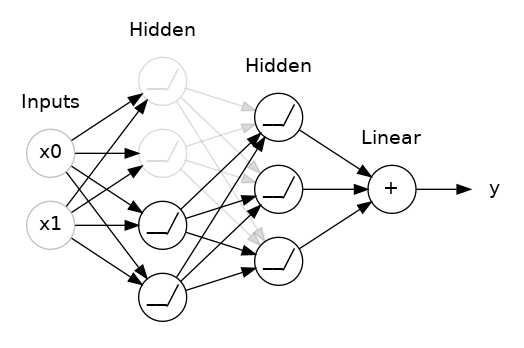

**Figure 1:** An animation of dropout in a neural network during training.

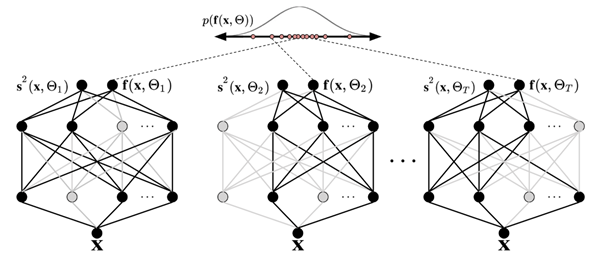

**Figure 2:** An ensemble of neural networks created by using dropout.
[Source to image.](https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/mc-dropout.html) Note that there are two output nodes here- and we will model both NOW!

# EDA: CA housing
Look how slick the bubble plot is... sort the data so that the biggest values are plotted last.

In [ ]:
# I was using sklearn but for some reason, it stopped downloading...
# We will use Colab dummy data and update names
import pandas as pd
housing = pd.read_csv('/content/sample_data/california_housing_train.csv')

In [ ]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [ ]:
# Dictionary mapping: Colab names -> Sklearn style names
column_mapping = {
    'longitude': 'Longitude',
    'latitude': 'Latitude',
    'housing_median_age': 'HouseAge',
    'total_rooms': 'AveRooms', # Note: Sklearn uses averages, but for renaming:
    'total_bedrooms': 'AveBedrms',
    'population': 'Population',
    'households': 'Occupancy',
    'median_income': 'MedInc',
    'median_house_value': 'MedHouseVal'
}

# Apply the rename
housing = housing.rename(columns=column_mapping)

# Display the result
print(housing.columns)
housing.head()

Index(['Longitude', 'Latitude', 'HouseAge', 'AveRooms', 'AveBedrms',
       'Population', 'Occupancy', 'MedInc', 'MedHouseVal'],
      dtype='object')


,Longitude,Latitude,HouseAge,AveRooms,AveBedrms,Population,Occupancy,MedInc,MedHouseVal
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


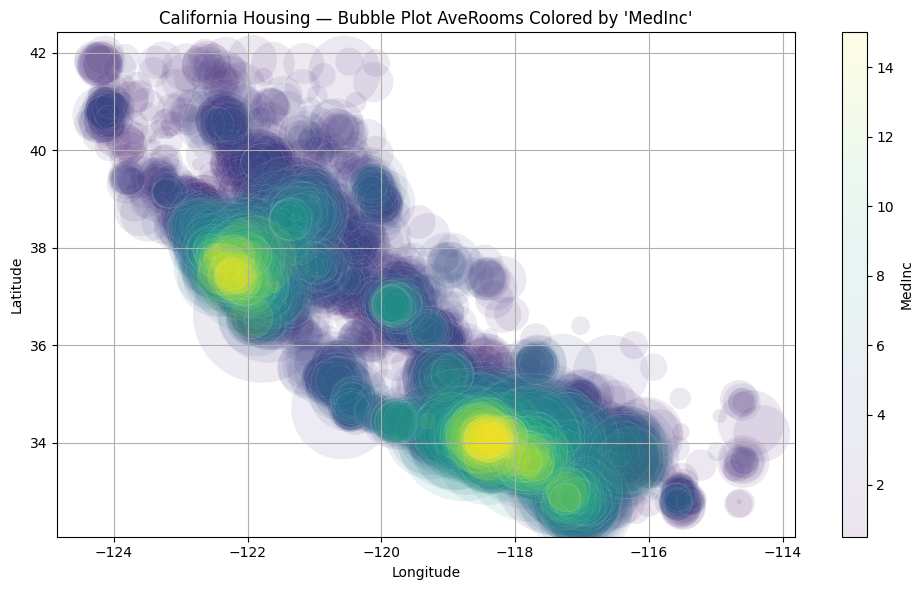

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose variable to color by
color_by = 'MedInc'

# Extract data
df_full = housing.copy()
df_full['target'] = housing['MedHouseVal']

# For z-ordering: sort so high color_by values appear on top
df_plot = df_full.copy()
df_plot['Latitude'] = df_plot['Latitude']
df_plot['Longitude'] = df_plot['Longitude']
df_plot['AveRooms'] = df_plot['AveRooms']
df_plot = df_plot.sort_values(by=color_by)

# Plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_plot['Longitude'],
    df_plot['Latitude'],
    c=df_plot[color_by],
    cmap='viridis',
    s=df_plot['AveRooms']*0.3,     # bubble size based on AveRooms
    alpha=0.1,
    edgecolor='white',
    linewidth=0.5
)
plt.colorbar(sc, label=color_by)
plt.title(f"California Housing — Bubble Plot AveRooms Colored by '{color_by}'")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

Regions with high house prices and sparse data tend to generate more uncertainty!

# Loss function
The Math Behind the "Two-Headed" Loss

To train a model that understands its own limitations, we move beyond Mean Squared Error (MSE). We need a loss function that accounts for the Mean/Head1 ($\mu$) and the Variance/Head2 ($\sigma^2$) simultaneously. One loss function for two things.

1. For a single prediction, the loss is defined as:$$\text{Loss} = \frac{1}{2}\ln(\sigma^2) + \frac{(y_{\text{true}} - \mu)^2}{2\sigma^2}$$

2. How it Works (The Balancing Act)
* The model has to minimize two competing terms:
  * The Accuracy Term $\frac{(y_{\text{true}} - \mu)^2}{2\sigma^2}$
    * This is essentially the squared error scaled by the predicted uncertainty.If the model makes a large error ($y_{\text{true}} - \mu$), the only way to keep the loss low is to increase $\sigma^2$.
    * The Lesson: "If you know you're going to miss, admit you're uncertain."
  * The Complexity Penalty $\frac{1}{2}\ln(\sigma^2)$:This prevents the model from "cheating." Without this term, the model would simply predict infinite uncertainty ($\sigma^2 \to \infty$) for every data point to make the first term zero.
    * The Lesson: "You can't just claim ignorance for everything; there is a cost to being unsure."

# 🔵 A NN with two heads! Hard-coded dropout.
To handle Aleatoric uncertainty, we’ve added a second head to predict variance ($\sigma^2$) and implemented a Gaussian Negative Log-Likelihood (NLL) loss function. We will still do stochastic passes to estimate Epistemic Uncertainty (on the first head) later.

Dropout is hard-coded to `0.2`. I had problems converging with a `StandardScaler` so I'm gonna use minmax scaler.

In [ ]:
feature_cols = housing.columns[housing.columns != 'MedHouseVal']
feature_cols

Index(['Longitude', 'Latitude', 'HouseAge', 'AveRooms', 'AveBedrms',
       'Population', 'Occupancy', 'MedInc'],
      dtype='object')

Training with Min-Max Targets...
Epoch 1/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2476 - val_loss: -0.7029
Epoch 2/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.8476 - val_loss: -1.4467
Epoch 3/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.3399 - val_loss: -1.5328
Epoch 4/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.4657 - val_loss: -1.6282
Epoch 5/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -1.5456 - val_loss: -1.6615
Epoch 6/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.5792 - val_loss: -1.6520
Epoch 7/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.6051 - val_loss: -1.6905
Epoch 8/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -1.6340 - val_loss: -1.6661
Epoch 9/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -1.6446 - val_loss: -1.6732
Epoch 10/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.6557 - val_loss: -1.7172
Epoch 11/300
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.6845 - val_l

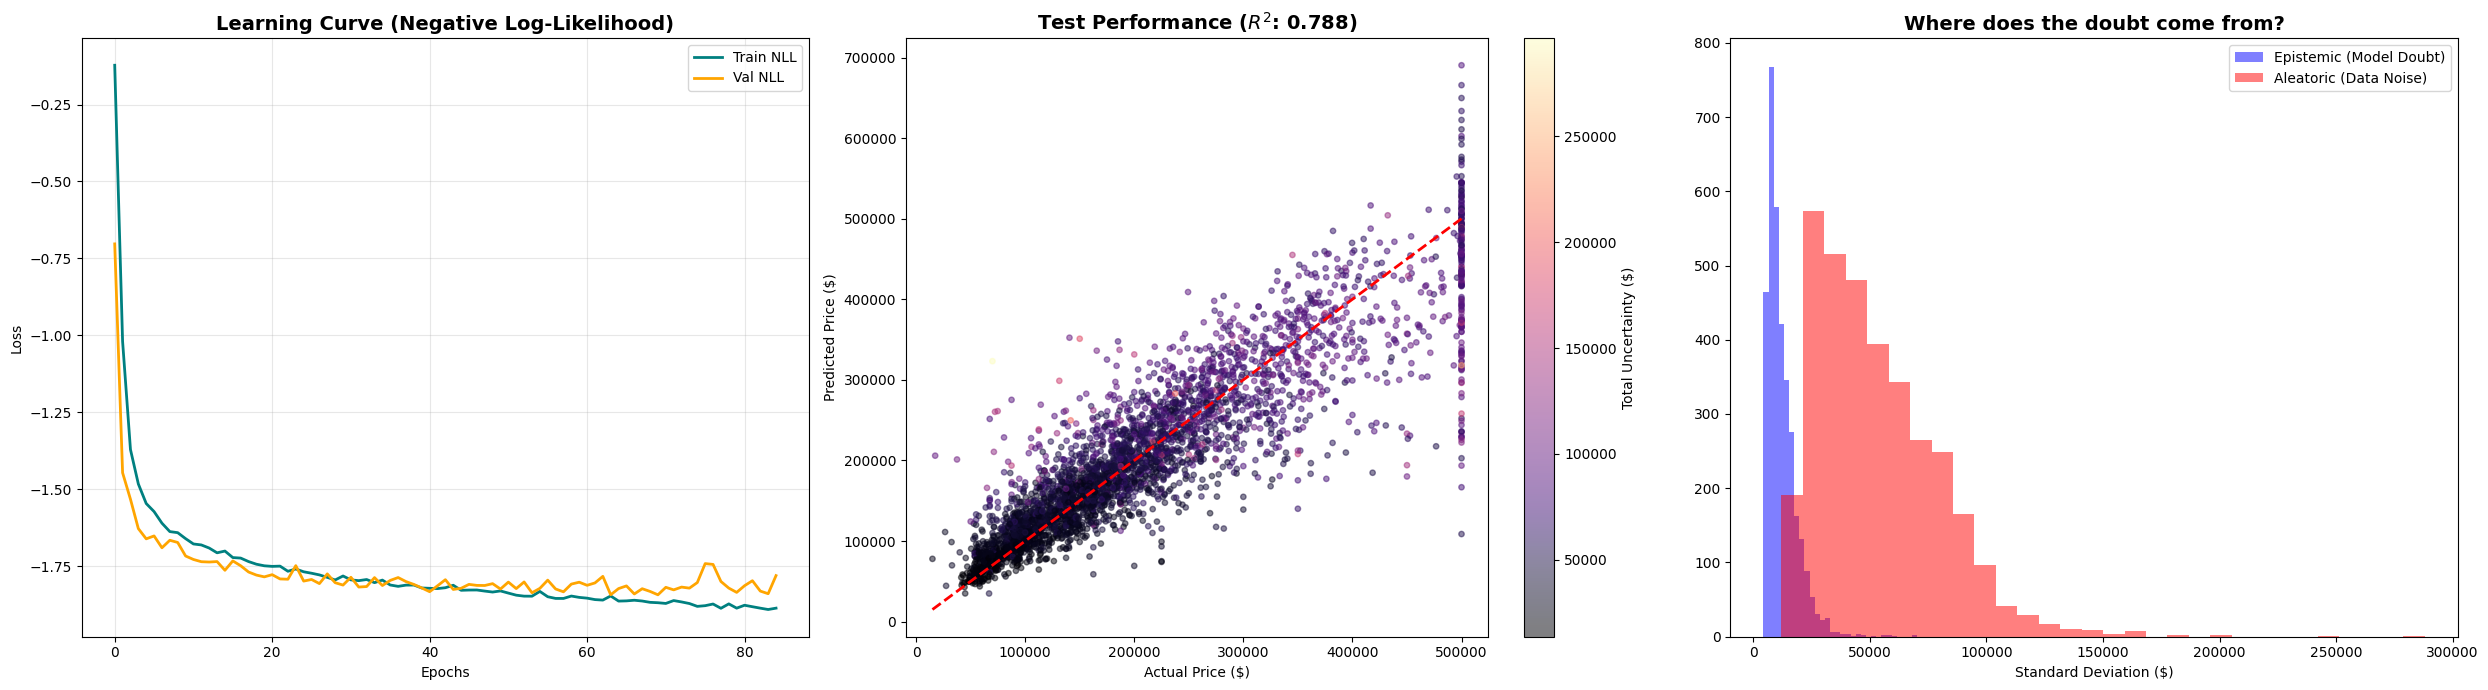

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. DATA PREP: MIN-MAX SCALING ---
X_raw = housing[feature_cols].values
y_raw = housing['MedHouseVal'].values # Actual dollars

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

# --- 2. LOSS & MODEL ---
def aleatoric_loss(y_true, y_pred):
    mu = y_pred[:, 0:1]
    sigma_sq = y_pred[:, 1:2]
    epsilon = 1e-6
    return tf.reduce_mean(0.5 * tf.math.log(sigma_sq + epsilon) +
                          0.5 * tf.math.divide(tf.square(y_true - mu), sigma_sq + epsilon))

def make_combined_model():
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x, training=True)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    mu = Dense(1, name="mu")(x)
    sigma_sq = Dense(1, activation='softplus', name="sigma_sq")(x)

    return tf.keras.Model(inputs=inputs, outputs=Concatenate()([mu, sigma_sq]))

# --- 3. TRAIN ---
model = make_combined_model()
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=aleatoric_loss)

print("Training with Min-Max Targets...")
# We capture the history object here
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2,
                    callbacks=[EarlyStopping(patience=15, restore_best_weights=True)], verbose=1)

# --- 4. INFERENCE & REVERSE SCALING ---
T = 100

# this is the 100 brains' from your model
# gives a 3D cube of iteration, mean, variance
preds = np.stack([model(X_test, training=True).numpy() for _ in range(T)])

# epistemic
mu_scaled = preds[:, :, 0]
all_mu_dollars = scaler_y.inverse_transform(mu_scaled.reshape(-1, 1)).reshape(T, -1)

# aleatoric
y_range = scaler_y.data_range_[0]
all_sigma_sq_dollars = preds[:, :, 1] * (y_range**2)

final_mean = all_mu_dollars.mean(axis=0)
# combine the two
total_std = np.sqrt(all_mu_dollars.var(axis=0) + all_sigma_sq_dollars.mean(axis=0))

# --- 5. VISUALIZATION: NOW WITH LEARNING CURVE ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

# Plot A: Learning Curve
ax1.plot(history.history['loss'], label='Train NLL', color='teal', lw=2)
ax1.plot(history.history['val_loss'], label='Val NLL', color='orange', lw=2)
ax1.set_title("Learning Curve (Negative Log-Likelihood)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot B: Scatter Performance
r2 = r2_score(y_test_raw, final_mean)
sc = ax2.scatter(y_test_raw, final_mean, c=total_std, cmap='magma', alpha=0.5, s=15)
ax2.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--', lw=2)
fig.colorbar(sc, ax=ax2, label="Total Uncertainty ($)")
ax2.set_title(f"Test Performance ($R^2$: {r2:.3f})", fontsize=14, fontweight='bold')
ax2.set_xlabel("Actual Price ($)")
ax2.set_ylabel("Predicted Price ($)")

# Plot C: Uncertainty Decomposition
ax3.hist(np.sqrt(all_mu_dollars.var(axis=0)), bins=30, alpha=0.5, label='Epistemic (Model Doubt)', color='blue')
ax3.hist(np.sqrt(all_sigma_sq_dollars.mean(axis=0)), bins=30, alpha=0.5, label='Aleatoric (Data Noise)', color='red')
ax3.set_title("Where does the doubt come from?", fontsize=14, fontweight='bold')
ax3.set_xlabel("Standard Deviation ($)")
ax3.legend()

plt.tight_layout()
plt.show()

In a moment, we will combine these two things. To get the "Humble Model" results we want, we combine them. Even though Aleatoric is calculated in one pass, we take the average Aleatoric value across all 100 passes to get a more stable estimate. See how one is a variance and one is a mean of the variance?!

$$\sigma^2_{total} = \underbrace{\text{Var}(\mu)}_{\text{Epistemic (Spread of Heads)}} + \underbrace{\text{Mean}(\sigma^2)}_{\text{Aleatoric (Average of Noise Head)}}$$

#⭐ Point-wise emprical coverage

## 🔴 Gaussian

In [ ]:
# Create a mask of (100 passes, 3400 houses)
# Each pass has its own mu and its own sigma_sq
mu_samples = all_mu_dollars # Shape (100, 3400)
sigma_samples = np.sqrt(all_sigma_sq_dollars) # Shape (100, 3400)

# For every single pass, did THAT specific 'brain' capture the truth?
# We use the Gaussian bound for EACH pass
individual_hit_mask = (y_test_raw >= mu_samples - 1.96 * sigma_samples) & \
                      (y_test_raw <= mu_samples + 1.96 * sigma_samples)

# Now we calculate the hit rate PER HOUSE (Mean across the 100 passes)
house_hit_rates = np.mean(individual_hit_mask, axis=0) # Shape (3400,)

print(f"Shape of Hit Rates: {house_hit_rates.shape}")
print(f"Average hit rate across all houses: {np.mean(house_hit_rates):.2%}")

Shape of Hit Rates: (3400,)
Average hit rate across all houses: 95.13%


You can now plot this to see if there are specific price ranges where the model becomes "unreliable." Each house was predicted 100 times... most of the times, it's above the red line! Trouble at the extremes of course.... many misses.... agrees with the scatterplot.

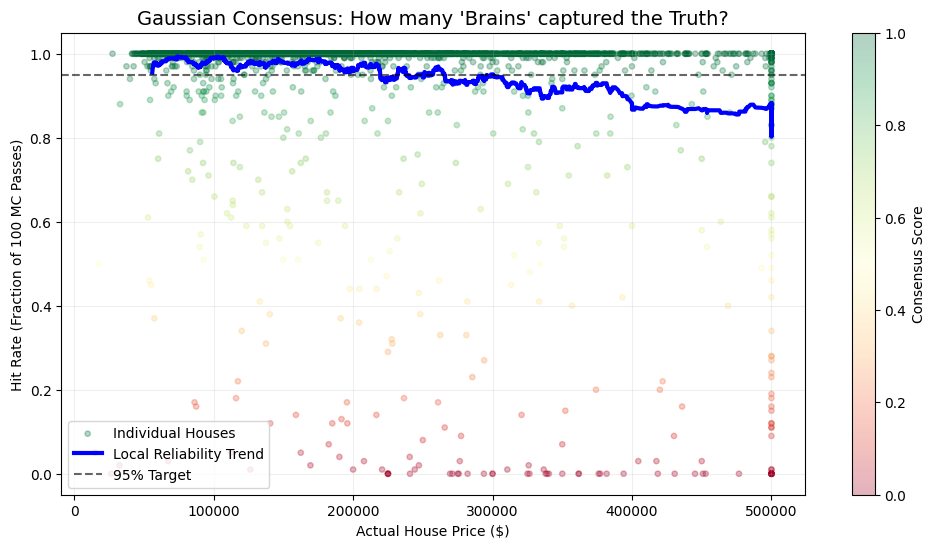

In [ ]:
import pandas as pd

# 1. 'house_hit_rates' is our Y-axis (from your code)
# 2. 'y_test_raw' is our X-axis

plt.figure(figsize=(12, 6))

# Scatter plot: color points by their hit rate (Green = High Consensus, Red = Disagreement)
plt.scatter(y_test_raw, house_hit_rates, alpha=0.3,
            c=house_hit_rates, cmap='RdYlGn', s=15, label='Individual Houses')

# 3. Add a Rolling Mean to show "Reliability Zones"
# This helps students see if the model fails more on expensive vs. cheap houses
df_trend = pd.DataFrame({'price': y_test_raw, 'hit_rate': house_hit_rates}).sort_values('price')
df_trend['rolling_avg'] = df_trend['hit_rate'].rolling(window=150, center=True).mean()

plt.plot(df_trend['price'], df_trend['rolling_avg'], color='blue', lw=3, label='Local Reliability Trend')

# 4. Target Line (The 95% Promise)
plt.axhline(0.95, color='black', linestyle='--', alpha=0.6, label='95% Target')

plt.title("Gaussian Consensus: How many 'Brains' captured the Truth?", fontsize=14)
plt.xlabel("Actual House Price ($)")
plt.ylabel("Hit Rate (Fraction of 100 MC Passes)")
plt.ylim(-0.05, 1.05)
plt.colorbar(label="Consensus Score")
plt.legend(loc='lower left')
plt.grid(alpha=0.2)
plt.show()

## 🔴 Empirical

In [ ]:
# --- 1. EXTRACT & SCALE THE BRAINS ---
# Extract mu and sigma_sq from your 'preds' cube
# preds shape is (T, N, 2)
mu_samples_scaled = preds[:, :, 0]
sigma_sq_samples_scaled = preds[:, :, 1]

# Convert mu samples to Dollars
mu_samples = scaler_y.inverse_transform(mu_samples_scaled.reshape(-1, 1)).reshape(T, -1)

# Convert sigma_sq to Dollar variance
sigma_sq_samples = sigma_sq_samples_scaled * (y_range**2)

# --- 2. GENERATE THE SAMPLES (T=100, N=3400) ---
# Now that we have dollar-scale mu and sigma_sq, this won't crash!
full_samples = np.random.normal(loc=mu_samples, scale=np.sqrt(sigma_sq_samples))

# --- 3. CALCULATE POINT-WISE EMPIRICAL BOUNDS ---
emp_lower = np.percentile(full_samples, 2.5, axis=0)
emp_upper = np.percentile(full_samples, 97.5, axis=0)

# --- 4. POINT-WISE TRUTH TEST ---
# Ensure y_test_raw is in dollars
emp_hit_mask = (y_test_raw >= emp_lower) & (y_test_raw <= emp_upper)
emp_coverage = np.mean(emp_hit_mask)

print(f"✅ Empirical 95% Coverage: {emp_coverage:.2%}")

if emp_coverage < 0.90:
    print("⚠️ ALERT: Coverage is low. The model is overconfident (underestimating noise).")
else:
    print("🎯 Target Hit: The model's uncertainty captures reality.")

✅ Empirical 95% Coverage: 95.79%
🎯 Target Hit: The model's uncertainty captures reality.


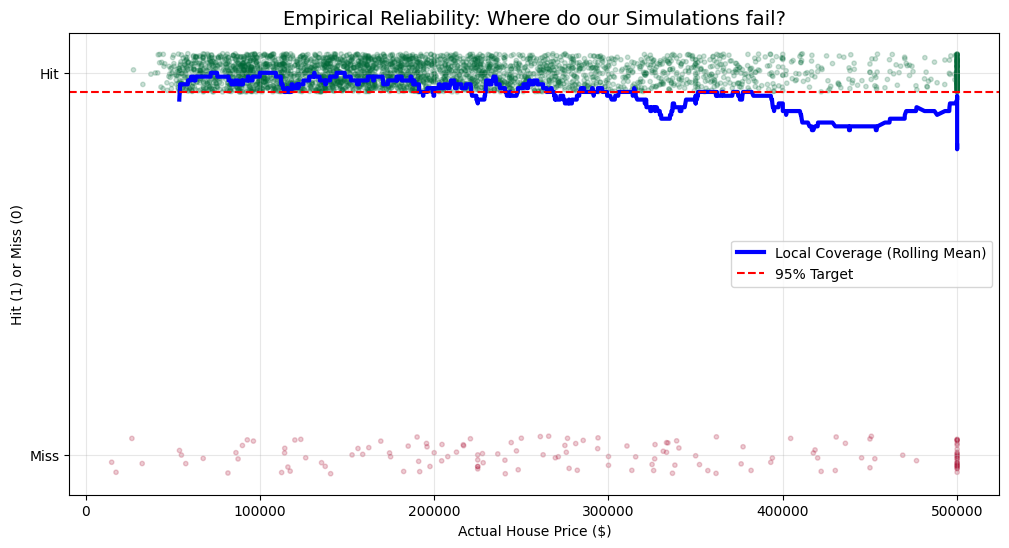

In [ ]:
# 1. Ensure we are using the Empirical Hit Mask (True/False for each house)
# This is based on the 2.5th and 97.5th percentiles of the 100 simulations
emp_hits = emp_hit_mask.astype(int)

plt.figure(figsize=(12, 6))

# We use a scatter plot with a bit of 'jitter' on the Y-axis
# so you can see the density of the hits vs misses
jitter = np.random.uniform(-0.05, 0.05, size=len(emp_hits))

plt.scatter(y_test_raw, emp_hits + jitter, alpha=0.2,
            c=emp_hits, cmap='RdYlGn', s=10)

# Add a rolling mean to show the 'Local Coverage' across price ranges
import pandas as pd
df_reliability = pd.DataFrame({'price': y_test_raw, 'hit': emp_hits}).sort_values('price')
df_reliability['rolling_coverage'] = df_reliability['hit'].rolling(window=100, center=True).mean()

plt.plot(df_reliability['price'], df_reliability['rolling_coverage'],
         color='blue', lw=3, label='Local Coverage (Rolling Mean)')

plt.axhline(0.95, color='red', linestyle='--', label='95% Target')

plt.title("Empirical Reliability: Where do our Simulations fail?", fontsize=14)
plt.xlabel("Actual House Price ($)")
plt.ylabel("Hit (1) or Miss (0)")
plt.yticks([0, 1], ["Miss", "Hit"])
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## ⭐ Loop through different dropout rates
It tells your model how anxious or cautious to be.

In [ ]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score, mean_absolute_error
# from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, Concatenate
# from tensorflow.keras.callbacks import EarlyStopping

# # --- 1. THE ARCHITECTURE & LOSS ---
# def aleatoric_loss(y_true, y_pred):
#     mu = y_pred[:, 0:1]
#     sigma_sq = y_pred[:, 1:2]
#     epsilon = 1e-6
#     return tf.reduce_mean(0.5 * tf.math.log(sigma_sq + epsilon) +
#                           0.5 * tf.math.divide(tf.square(y_true - mu), sigma_sq + epsilon))

# def make_combined_model_tuned(dropout_rate):
#     inputs = Input(shape=(X_train.shape[1],))
#     x = Dense(128, activation='relu')(inputs)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout_rate)(x, training=True)

#     x = Dense(64, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout_rate)(x, training=True)

#     mu = Dense(1, name="mu")(x)
#     sigma_sq = Dense(1, activation='softplus', name="sigma_sq")(x)

#     return tf.keras.Model(inputs=inputs, outputs=Concatenate()([mu, sigma_sq]))

# # --- 2. THE TUNING LOOP ---
# dropout_rates = [0.1, 0.2, 0.4, 0.6]
# T = 50

# print(f"{'Rate':<5} | {'R2':<6} | {'E-Cov':<7} | {'Epistemic':<10} | {'Aleatoric':<10} | {'Combined'}")
# print("-" * 75)

# for rate in dropout_rates:
#     # Build & Train
#     temp_model = make_combined_model_tuned(rate)
#     temp_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=aleatoric_loss)

#     temp_model.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.2,
#                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)

#     # Monte Carlo Inference (The '100 Brains')
#     preds = np.stack([temp_model(X_test, training=True).numpy() for _ in range(T)])

#     # Reverse Scaling
#     all_mu_dollars = scaler_y.inverse_transform(preds[:, :, 0].reshape(-1, 1)).reshape(T, -1)
#     y_range = scaler_y.data_range_[0]
#     all_sigma_sq_dollars = preds[:, :, 1] * (y_range**2)

#     # --- CALCULATING INDIVIDUAL WIDTHS (95% Bounds) ---
#     # Epistemic: Just the spread of the means (1.96 * std of mu)
#     epistemic_std = np.sqrt(all_mu_dollars.var(axis=0))
#     avg_epistemic_width = np.mean(1.96 * epistemic_std)

#     # Aleatoric: Just the predicted noise head (1.96 * sqrt of mean sigma_sq)
#     aleatoric_std = np.sqrt(all_sigma_sq_dollars.mean(axis=0))
#     avg_aleatoric_width = np.mean(1.96 * aleatoric_std)

#     # Combined (Empirical): Percentiles of the full simulated samples
#     full_samples = np.random.normal(loc=all_mu_dollars, scale=np.sqrt(all_sigma_sq_dollars))
#     e_low = np.percentile(full_samples, 2.5, axis=0)
#     e_high = np.percentile(full_samples, 97.5, axis=0)
#     e_cov = np.mean((y_test_raw >= e_low) & (y_test_raw <= e_high))
#     avg_combined_width = np.mean(e_high - e_low)

#     # Metrics
#     final_mean = all_mu_dollars.mean(axis=0)
#     r2 = r2_score(y_test_raw, final_mean)

#     print(f"{rate:<5} | {r2:<6.3f} | {e_cov:<7.1%} | ${avg_epistemic_width:<9.0f} | ${avg_aleatoric_width:<9.0f} | ${avg_combined_width:,.0f}")

Maybe I would re-run with 0.1 for this one afterall! narrower bands with  good coverage and good R2!

# 🔵 SHAP
To update SHAP for the dual-headed model, we are going to create two explainers.

The first explains the Price (Mean), and the others explain the Uncertainty (Total Standard Deviation). This is a powerful teaching moment: students can see that while "Median Income" might drive the price up, "Longitude/Latitude" might be what drives the model's uncertainty.

## 🔴 Mean and Doubt (Epistemic, Aleatoric, Combined)

In [ ]:
# --- 1. REPAIRED DOLLAR PREDICTORS (Synced with your Scaler) ---

def predict_mean_final(x_np):
    # Ensure it's a tensor for the model
    preds = model(x_np, training=False)
    # Extract Mu (index 0)
    mu_scaled = preds[0].numpy() if isinstance(preds, list) else preds.numpy()[:, 0]
    # Use your ACTUAL scaler to be safe
    return scaler_y.inverse_transform(mu_scaled.reshape(-1, 1)).flatten()

def predict_epistemic_final(x_np):
    # 50 brains to find disagreement
    preds = np.stack([model(x_np, training=True) for _ in range(50)])
    mu_samples = preds[:, 0, :, 0] if isinstance(preds[0], list) else preds[:, :, 0]

    # Transform all samples to dollar space first
    all_mu_dollars = np.stack([
        scaler_y.inverse_transform(mu_samples[i].reshape(-1, 1)).flatten()
        for i in range(50)
    ])
    return all_mu_dollars.std(axis=0)

def predict_aleatoric_final(x_np):
    # Get the model output (Mean and Sigma_sq)
    preds = model(x_np, training=False)

    # Extract the sigma_sq head (index 1)
    # Handle list output for multi-head models or array output for single-head
    sigma_sq_scaled = preds[1].numpy() if isinstance(preds, list) else preds.numpy()[:, 1]

    # Conversion: Sigma_sq is variance in scaled space.
    # To get Dollars, we multiply by (y_range^2) and then take the square root.
    sigma_sq_dollars = sigma_sq_scaled.flatten() * (y_range**2)
    return np.sqrt(sigma_sq_dollars)

# --- 1. SET THE STAGE ---
X_subset = X_test[:40]

# --- UPDATED DICTIONARY ---
surgical_predictors = {
    "Price (Mean)": predict_mean_final,
    "Model Doubt (Epistemic)": predict_epistemic_final,
    "Data Noise (Aleatoric)": predict_aleatoric_final
}

# --- 2. CORRECTED PULSE CHECK (No .values error) ---
# X_subset is a numpy array, so we pass it directly
test_prices = predict_mean_final(X_subset)

print("--- 10-SECOND PULSE CHECK ---")
print(f"Sample Price 1: ${test_prices[0]:,.2f}")
print(f"Sample Price 2: ${test_prices[1]:,.2f}")
print(f"Standard Dev:    {test_prices.std():.4f}")

if test_prices.std() < 1:
    print("🚨 ALERT: Still no variance. Check if model.predict(X_subset) returns different values!")

--- 10-SECOND PULSE CHECK ---
Sample Price 1: $126,965.11
Sample Price 2: $428,468.22
Standard Dev:    98755.8203


Deep-scanning Price (Mean)... (Resolution: nsamples=500)


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-3373903857.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X_subset, feature_names=feature_cols, show=False)


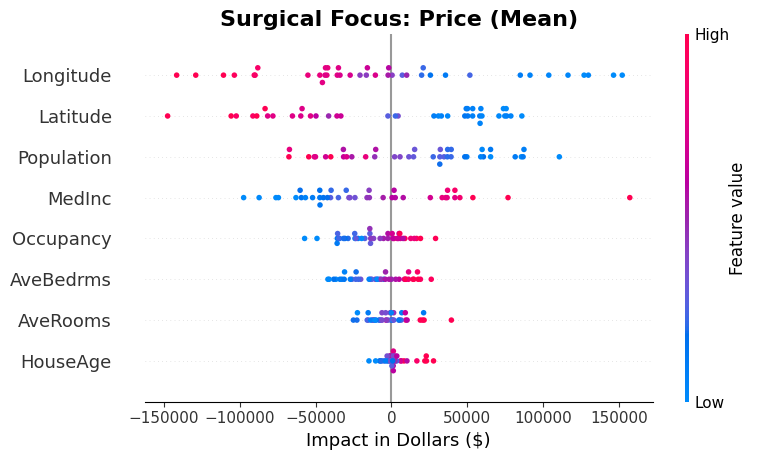

Deep-scanning Model Doubt (Epistemic)... (Resolution: nsamples=500)


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-3373903857.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X_subset, feature_names=feature_cols, show=False)


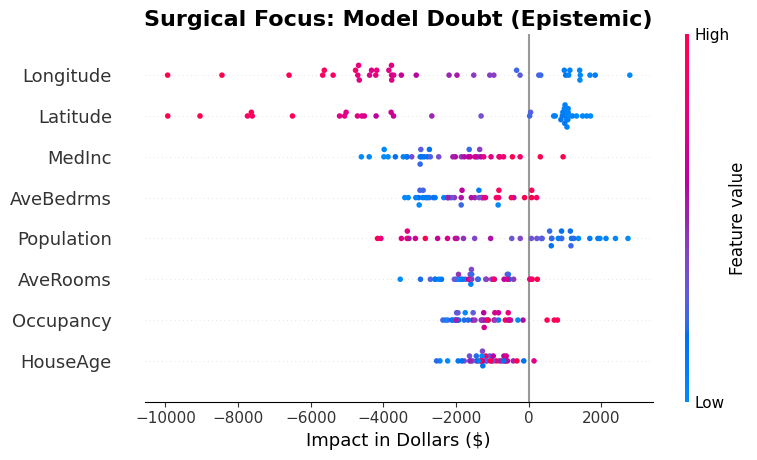

Deep-scanning Data Noise (Aleatoric)... (Resolution: nsamples=500)


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-3373903857.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X_subset, feature_names=feature_cols, show=False)


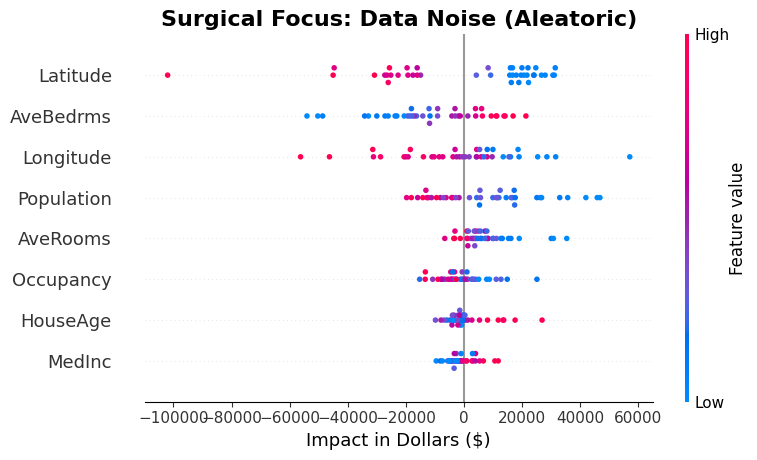

In [ ]:
import shap
import matplotlib.pyplot as plt

# vibrant background
# Use a diverse background for better resolution
background_vibrant = shap.sample(X_train, 100)

# --- 2. EXECUTE THE SCAN ---
for title, func in surgical_predictors.items():
    print(f"Deep-scanning {title}... (Resolution: nsamples=500)")

    # KernelExplainer interprets the 'signal' we just verified
    explainer = shap.KernelExplainer(func, background_vibrant)

    # nsamples=500 is the sweet spot for clarity without a long wait
    sv = explainer.shap_values(X_subset, nsamples=500)

    if isinstance(sv, list):
        sv = sv[0]

    plt.figure(figsize=(10, 6))
    # We use the verified feature_cols from your previous cell
    shap.summary_plot(sv, X_subset, feature_names=feature_cols, show=False)

    plt.title(f"Surgical Focus: {title}", fontsize=16, fontweight='bold')
    plt.xlabel("Impact in Dollars ($)")
    plt.tight_layout()
    plt.show()

# 🔵 Dependence plots
Similar to partial dependence plot.

## 🔴 No secondary color, all 4 quantities

Analyzing Price (Mean) dependency...


  0%|          | 0/50 [00:00<?, ?it/s]

Analyzing Model Doubt (Epistemic) dependency...


  0%|          | 0/50 [00:00<?, ?it/s]

Analyzing Data Noise (Aleatoric) dependency...


  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

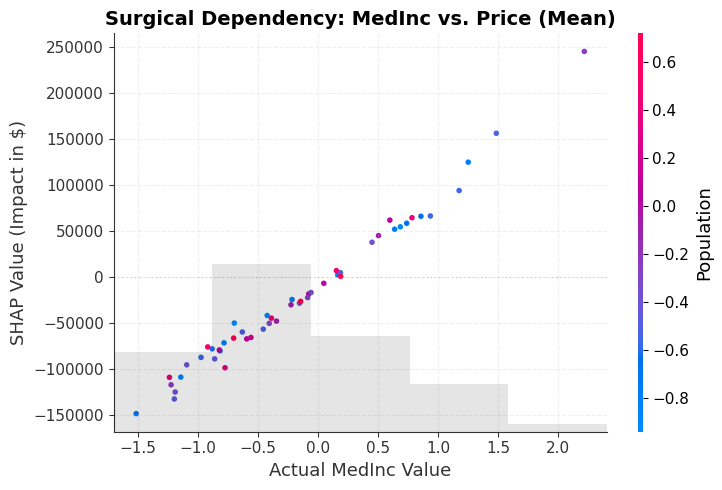

<Figure size 1000x600 with 0 Axes>

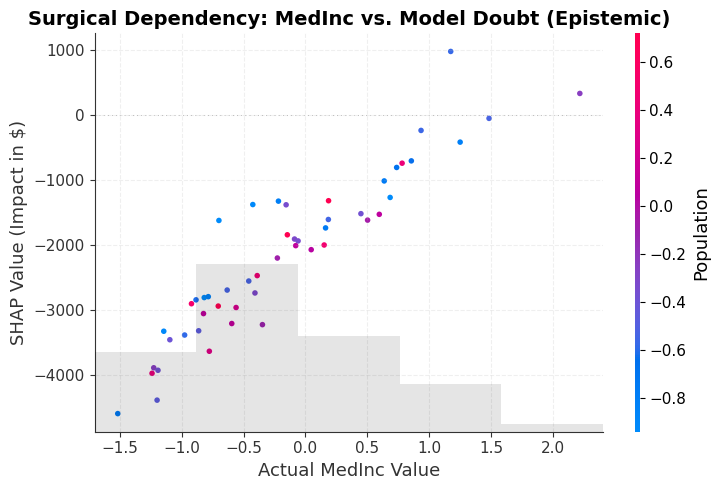

<Figure size 1000x600 with 0 Axes>

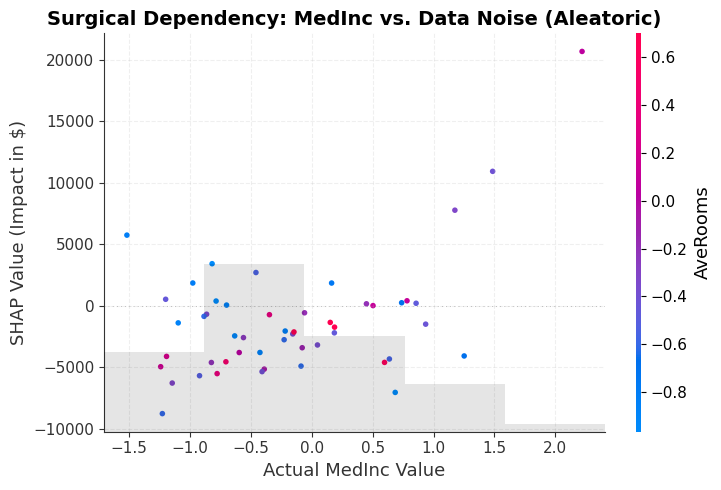

In [ ]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# --- 1. PREP THE EXPLANATIONS ---
# We use the verified surgical_predictors and a vibrant background
background_vibrant = shap.sample(X_train, 100)
X_subset = X_test[:50]

explanations = {}

for title, func in surgical_predictors.items():
    print(f"Analyzing {title} dependency...")

    # High resolution: 500 samples to ensure the scatter curve is smooth
    expl = shap.KernelExplainer(func, background_vibrant)
    sv = expl.shap_values(X_subset, nsamples=500)

    if isinstance(sv, list):
        sv = sv[0]

    # Build the object for advanced plotting
    explanations[title] = shap.Explanation(
        values=sv,
        data=X_subset,
        feature_names=feature_cols,
        base_values=expl.expected_value
    )

# --- 2. INDEPENDENT SCATTER PLOTS ---
target_feature = "MedInc"

for title, exp in explanations.items():
    # Fresh figure for each 'brain'
    plt.figure(figsize=(10, 6))

    # Passing color=exp allows SHAP to pick an interaction feature automatically
    # This turns your 2D plot into a 3D-info plot with a color bar
    shap.plots.scatter(exp[:, target_feature], color=exp, show=False)

    # Standard surgical styling
    plt.title(f"Surgical Dependency: {target_feature} vs. {title}", fontsize=14, fontweight='bold')
    plt.ylabel(f"SHAP Value (Impact in $)")
    plt.xlabel(f"Actual {target_feature} Value")
    plt.grid(alpha=0.2, linestyle='--')

    plt.tight_layout()
    plt.show()

The scatter plots reveal the "mathematical personality" of each output head:

* Price (Mean) Dependency: This shows a nearly linear relationship with MedInc. As actual income increases, the SHAP impact (in dollars) climbs steadily toward +$250,000.

* Model Doubt (Epistemic) Dependency: This is a fascinating result. The impact is negative for low-income areas and climbs toward zero (or positive) as income increases. This suggests the model is more "certain" (lower doubt) about low-income predictions but becomes increasingly "confused" or varied in its opinion as house prices rise.

* Data Noise (Aleatoric) Dependency: This plot looks much noisier, as it should. It captures the inherent market volatility that doesn't follow a simple linear trend with income, hovering mostly between `-$10,000` and `+$10,000` in impact.

# 🔴 Inspect an individual row
Pick a row, any row! More us, let's pick the one where the model is 'most nervous'. Where the sample had the highest SD over the 30 stochastic passes?

### Find the most interesting row...

In [ ]:
# --- 1. ROBUST SCALER EXTRACTION ---
if hasattr(scaler_y, 'mean_'): # StandardScalar
    y_mean = float(scaler_y.mean_[0])
    y_std = float(scaler_y.scale_[0])
    print("Detected: StandardScaler")
elif hasattr(scaler_y, 'min_'): # MinMaxScaler
    # For MinMaxScaler: Original = (Scaled * data_range) + min
    y_mean = float(scaler_y.min_[0])
    y_std = float(scaler_y.data_range_[0])
    print("Detected: MinMaxScaler")
else:
    # Fallback if no scaler was used (not recommended)
    y_mean, y_std = 0.0, 1.0
    print("⚠️ Warning: Scaler type unknown. Defaulting to 0/1.")

y_range = float(scaler_y.data_range_[0])

print(f"✅ SYNC FIXED:")
print(f"   y_mean: {y_mean:,.2f} | y_std: {y_std:,.2f} | y_range: {y_range:,.2f}")

Detected: MinMaxScaler
✅ SYNC FIXED:
   y_mean: -0.03 | y_std: 485,002.00 | y_range: 485,002.00


In [ ]:
# --- FIND THE MOST UNCERTAIN HOUSE (RECOVERED) ---
T_SEARCH = 30
# X_test_subset should be your numpy array of test data
all_preds = np.stack([model(X_test, training=True).numpy() for _ in range(T_SEARCH)])

# 1. Epistemic (Model Doubt): Variance of the Price head converted to Dollars
# Uses (y_std**2) because variance is the square of the scale
epistemic_var_dollars = all_preds[:, :, 0].var(axis=0) * (y_std**2)

# 2. Aleatoric (Data Noise): Mean of the Sigma head converted to Dollars
# Sigma head is variance; y_range**2 converts it to dollar variance
aleatoric_var_dollars = all_preds[:, :, 1].mean(axis=0) * (y_range**2)

# 3. Total Uncertainty in Dollars
total_var_dollars = epistemic_var_dollars + aleatoric_var_dollars
total_std_dollars = np.sqrt(total_var_dollars)

# 4. Find the most chaotic row
max_unc_idx = np.argmax(total_std_dollars)

print(f"--- SEARCH RESULTS ---")
print(f"Row with highest combined uncertainty: {max_unc_idx}")
print(f"Total Uncertainty (Std Dev): ${total_std_dollars[max_unc_idx]:,.2f}")
print(f" -> Breakdown: Model Doubt: ${np.sqrt(epistemic_var_dollars[max_unc_idx]):,.2f} | Data Noise: ${np.sqrt(aleatoric_var_dollars[max_unc_idx]):,.2f}")

--- SEARCH RESULTS ---
Row with highest combined uncertainty: 2364
Total Uncertainty (Std Dev): $296,635.59
 -> Breakdown: Model Doubt: $55,548.32 | Data Noise: $291,388.16


### How will I interpret?

For the first plot, you see which variables are contributing to the prediction
* Things like `MedInc` might be driving up the pred for this house compared to baseline.

Then imagine you find a house where the **Epistemic Waterfall** is dominated by `HouseAge`:

* "Hey, look! The model is confused about this house specifically because of its age. We probably don't have many 100-year-old houses in our dataset, so the '100 brains' are arguing over it."

Then you look at the **Aleatoric Waterfall** and see it's dominated by `Population`:

* "However, the market noise here is caused by the high population density. Even if we had a billion rows of data, high-density areas are just 'noisier'—people flip houses, prices vary wildly, and the model recognizes that this is an unpredictable neighborhood."

## Mean

Surgically dissecting House #2364...


  0%|          | 0/1 [00:00<?, ?it/s]

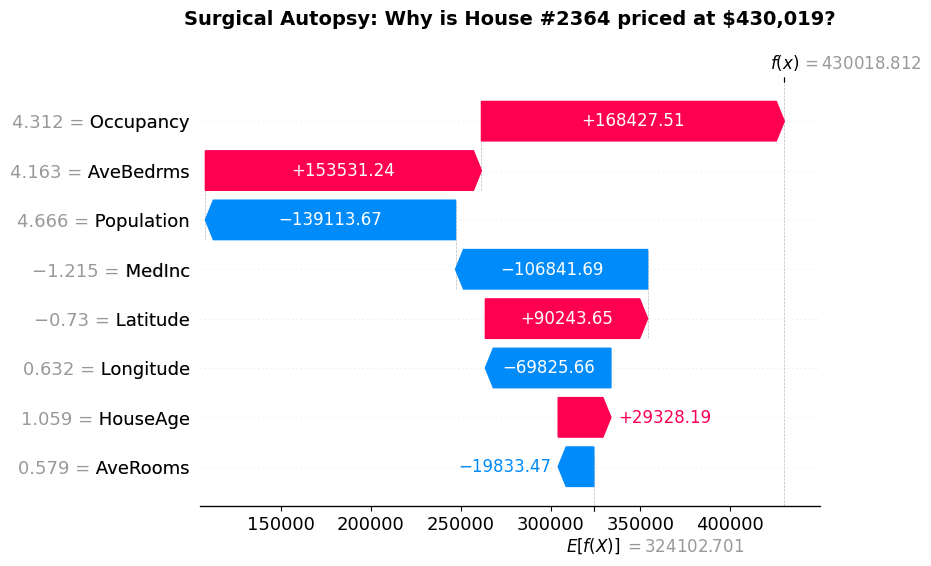

In [ ]:
# --- 1. SETUP THE EXPLAINER ---
# Using the verified mean predictor and background
explainer_waterfall = shap.KernelExplainer(predict_mean_final, background_vibrant)

# --- 2. CALCULATE FOR THE CHAOTIC HOUSE ---
print(f"Surgically dissecting House #{max_unc_idx}...")
# Use more nsamples for a single row to get high-precision dollar values
shap_values_single = explainer_waterfall.shap_values(X_test[max_unc_idx : max_unc_idx+1], nsamples=1000)

# Handle list output
if isinstance(shap_values_single, list):
    shap_values_single = shap_values_single[0]

# --- 3. CREATE THE EXPLANATION OBJECT ---
exp_single = shap.Explanation(
    values=shap_values_single[0],
    base_values=explainer_waterfall.expected_value,
    data=X_test[max_unc_idx],
    feature_names=feature_cols
)

# --- 4. PLOT THE WATERFALL ---
plt.figure(figsize=(10, 6))
# Note: waterfall() often manages its own figure, but this ensures a clean layout
shap.plots.waterfall(exp_single, show=False)
plt.title(f"Surgical Autopsy: Why is House #{max_unc_idx} priced at ${predict_mean_final(X_test[max_unc_idx:max_unc_idx+1])[0]:,.0f}?",
          fontsize=14, fontweight='bold', pad=20)
plt.show()

## With Doubt

Surgically dissecting Model Doubt (Epistemic) for House #2364...


  0%|          | 0/1 [00:00<?, ?it/s]

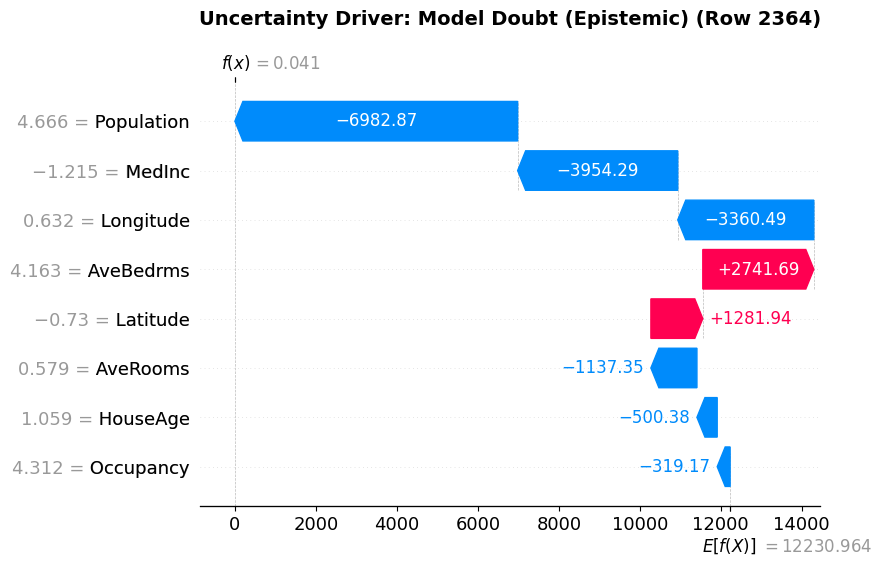

Surgically dissecting Data Noise (Aleatoric) for House #2364...


  0%|          | 0/1 [00:00<?, ?it/s]

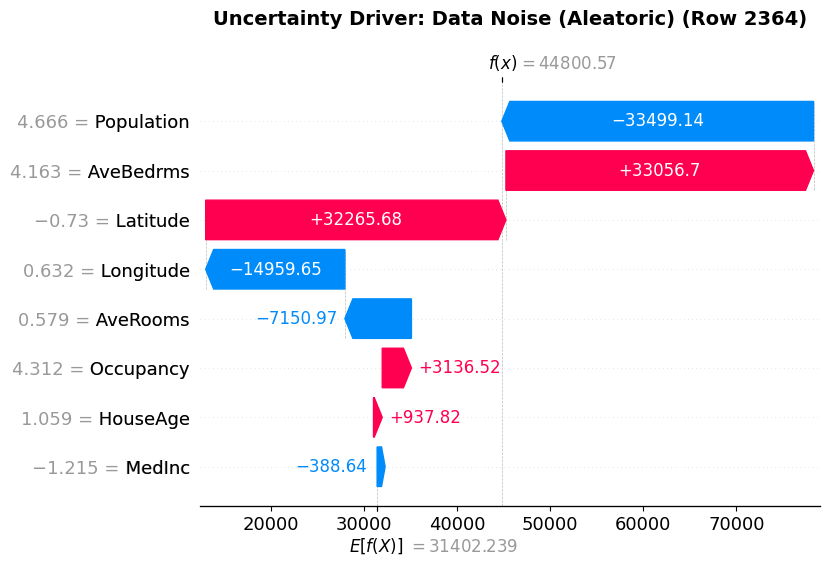

In [ ]:
# --- THE DUAL UNCERTAINTY DISSECTION ---
import matplotlib.pyplot as plt

uncertainty_targets = {
    "Model Doubt (Epistemic)": predict_epistemic_final,
    "Data Noise (Aleatoric)": predict_aleatoric_final
}

for title, func in uncertainty_targets.items():
    print(f"Surgically dissecting {title} for House #{max_unc_idx}...")

    # 1. Create specialized explainer for the uncertainty head
    explainer = shap.KernelExplainer(func, background_vibrant)
    sv = explainer.shap_values(X_test[max_unc_idx : max_unc_idx+1], nsamples=1000)

    if isinstance(sv, list): sv = sv[0]

    # 2. Wrap in Explanation object
    exp = shap.Explanation(
        values=sv[0],
        base_values=explainer.expected_value,
        data=X_test[max_unc_idx],
        feature_names=feature_cols
    )

    # 3. Plot
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(exp, show=False)
    plt.title(f"Uncertainty Driver: {title} (Row {max_unc_idx})", fontsize=14, fontweight='bold', pad=20)
    plt.show()

# ⭐ SHAP Values AND Espistemic  AND Aleatoric Uncertainty

# 🔵 2D Decision-Making Table

It’s important **not to conflate feature importance with uncertainty**.  
SHAP values and epistemic uncertainty answer *different* questions.

- **SHAP magnitude** → *Why* did the model make this prediction?
- **Epistemic + aleatoric uncertainty** → *How confident* is the model and data in this prediction?

| SHAP Magnitude | Epistemic + Aleatoric Uncertainty | Interpretation |
|---------------|----------------------|----------------|
| **High** | **Low** | 🔵 **Confident, strong signal**  
The 'Gold Standard.' The model knows *exactly* why it is predicting this value. |
| **High** | **High** | 🟠 **Strong claim, low confidence**  
The 'Extrapolation Zone.' The model is making a bold prediction, but it may be extrapolating. Use caution. |
| **Low** | **Low** | 🟢 **Boring but reliable**  
The 'Boring But Reliable'. Near-average prediction in a well-understood region of the data. |
| **Low** | **High** | 🔴 **Uncertain and uninformative**  
The 'Noise Floor.' The model is unsure *and* has no clear explanatory driver. |

---

## How to Read This Correctly

- **High SHAP ≠ uncertainty**  
  It means a feature strongly influenced the prediction.

> **SHAP explains *why* the model predicts something.  
> Epistemic uncertainty explains *how confident* the model is in that explanation.** Aleatoric uncertainty explains how noisy the data is.

In [ ]:
import numpy as np
import pandas as pd
import shap

# --- 1. GENERATE SHAP VALUES FOR ALL THREE BRAINS ---
# We use the background_vibrant and X_subset we established earlier
print("Generating SHAP values for all targets... (This may take a minute)")

# Define the targets to explain
targets = {
    'mean': predict_mean_final,
    'epistemic': predict_epistemic_final,
    'aleatoric': predict_aleatoric_final
}

sv_results = {}
for name, func in targets.items():
    explainer = shap.KernelExplainer(func, background_vibrant)
    # Using 500 samples for a balance of speed and precision
    sv = explainer.shap_values(X_subset, nsamples=500)
    if isinstance(sv, list): sv = sv[0]
    sv_results[name] = sv

# --- 2. EXTRACT MAGNITUDES ---
# Price Impact (Mean)
sv_mean = sv_results['mean']
shap_mag = np.abs(sv_mean).sum(axis=1)

# Total Uncertainty (Epistemic + Aleatoric)
sv_epistemic = sv_results['epistemic']
sv_aleatoric = sv_results['aleatoric']
unc_mag = np.abs(sv_epistemic).sum(axis=1) + np.abs(sv_aleatoric).sum(axis=1)

# --- 3. CREATE QUADRANTS ---
quad_df = pd.DataFrame({
    'idx': np.arange(len(X_subset)),
    'shap_mag': shap_mag,
    'unc_mag': unc_mag
})

s_mid = quad_df['shap_mag'].median()
u_mid = quad_df['unc_mag'].median()

def assign_quadrant(row):
    if row['shap_mag'] >= s_mid and row['unc_mag'] < u_mid:
        return "🔵 High Signal, Low Chaos (Trustworthy)"
    if row['shap_mag'] >= s_mid and row['unc_mag'] >= u_mid:
        return "🟠 High Signal, High Chaos (Risky)"
    if row['shap_mag'] < s_mid and row['unc_mag'] < u_mid:
        return "🟢 Low Signal, Low Chaos (Stable)"
    return "🔴 Low Signal, High Chaos (Unreliable)"

quad_df['category'] = quad_df.apply(assign_quadrant, axis=1)

# --- 4. RESULTS ---
best_confident_idx = quad_df[quad_df['category'] == "🔵 High Signal, Low Chaos (Trustworthy)"]['shap_mag'].idxmax()

print("\n--- QUADRANT DISTRIBUTION ---")
print(quad_df['category'].value_counts())
print(f"\n🎯 GOLD STANDARD HOUSE: Row {best_confident_idx}")

Generating SHAP values for all targets... (This may take a minute)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


--- QUADRANT DISTRIBUTION ---
category
🟢 Low Signal, Low Chaos (Stable)          19
🟠 High Signal, High Chaos (Risky)         19
🔵 High Signal, Low Chaos (Trustworthy)     6
🔴 Low Signal, High Chaos (Unreliable)      6
Name: count, dtype: int64

🎯 GOLD STANDARD HOUSE: Row 1


## 🔴 Plot Quadrants

Analyzing Price, Doubt, and Noise signals...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

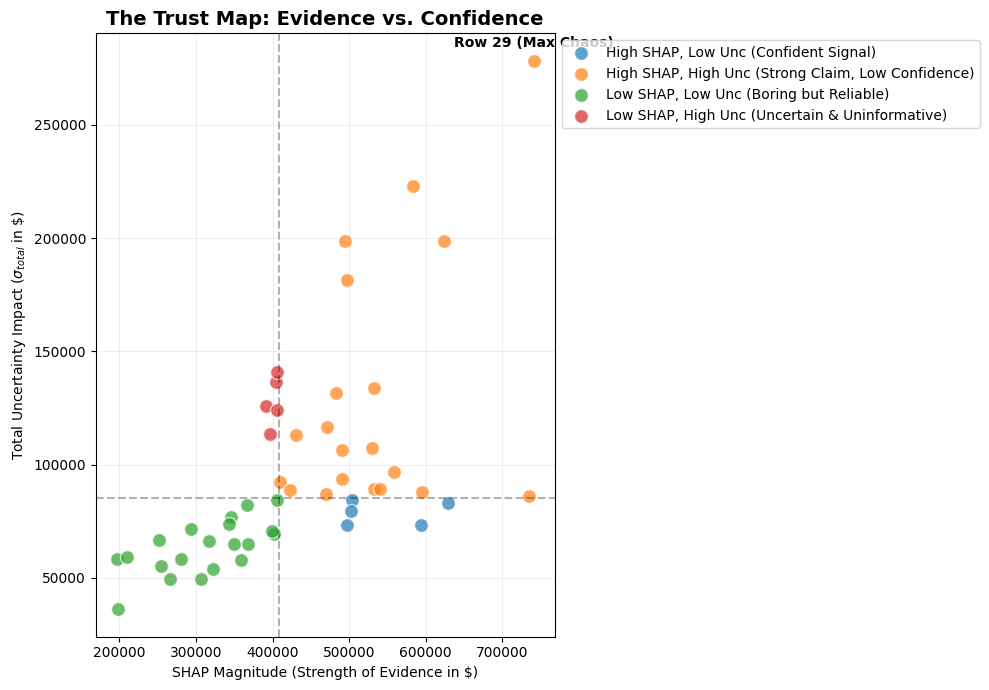

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# --- 1. GENERATE SHAP VALUES FOR ALL HEADS ---
# Ensuring variables are in memory for this subset
print("Analyzing Price, Doubt, and Noise signals...")
targets = {
    'mean': predict_mean_final,
    'epistemic': predict_epistemic_final,
    'aleatoric': predict_aleatoric_final
}

sv_results = {}
for name, func in targets.items():
    explainer = shap.KernelExplainer(func, background_vibrant)
    sv = explainer.shap_values(X_subset, nsamples=500)
    if isinstance(sv, list): sv = sv[0]
    sv_results[name] = sv

# --- 2. CALCULATE MAGNITUDES & CREATE QUADRANTS ---
shap_mag = np.abs(sv_results['mean']).sum(axis=1)
# Total Uncertainty = Sum of SHAP impacts on both doubt heads
unc_mag = np.abs(sv_results['epistemic']).sum(axis=1) + np.abs(sv_results['aleatoric']).sum(axis=1)

quad_df = pd.DataFrame({
    'idx': np.arange(len(X_subset)),
    'shap_mag': shap_mag,
    'unc_mag': unc_mag
})

s_mid = quad_df['shap_mag'].median()
u_mid = quad_df['unc_mag'].median()

def assign_quadrant(row):
    if row['shap_mag'] >= s_mid and row['unc_mag'] < u_mid: return "High SHAP, Low Unc"
    if row['shap_mag'] >= s_mid and row['unc_mag'] >= u_mid: return "High SHAP, High Unc"
    if row['shap_mag'] < s_mid and row['unc_mag'] < u_mid: return "Low SHAP, Low Unc"
    return "Low SHAP, High Unc"

quad_df['category'] = quad_df.apply(assign_quadrant, axis=1)

# --- 3. THE TRUST MAP PLOT ---
plt.figure(figsize=(10, 7))

# Plotting with the exact labels from the dictionary
categories = {
    "High SHAP, Low Unc": {"color": "#1f77b4", "desc": "(Confident Signal)"},
    "High SHAP, High Unc": {"color": "#ff7f0e", "desc": "(Strong Claim, Low Confidence)"},
    "Low SHAP, Low Unc": {"color": "#2ca02c", "desc": "(Boring but Reliable)"},
    "Low SHAP, High Unc": {"color": "#d62728", "desc": "(Uncertain & Uninformative)"}
}

for label, info in categories.items():
    mask = quad_df['category'] == label
    plt.scatter(
        quad_df.loc[mask, 'shap_mag'],
        quad_df.loc[mask, 'unc_mag'],
        c=info['color'],
        label=f"{label} {info['desc']}",
        alpha=0.7,
        edgecolors='w',
        s=100
    )

# Threshold lines
plt.axvline(s_mid, color='black', linestyle="--", alpha=0.3)
plt.axhline(u_mid, color='black', linestyle="--", alpha=0.3)

# Label the most "Dangerous" point
top_point_idx = quad_df['unc_mag'].idxmax()
top_point = quad_df.loc[top_point_idx]
plt.annotate(f"Row {top_point_idx} (Max Chaos)",
             (top_point['shap_mag'], top_point['unc_mag']),
             textcoords="offset points", xytext=(0, 10), ha='center', fontweight='bold')

# Formatting with LaTeX
plt.xlabel(r"SHAP Magnitude (Strength of Evidence in \$)")
plt.ylabel(r"Total Uncertainty Impact ($\sigma_{total}$ in \$)")
plt.title("The Trust Map: Evidence vs. Confidence", fontsize=14, fontweight='bold')
plt.legend(frameon=True, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

## 🔴 Sample one point from each group

and now a waterfall for each!

✅ Selection successful: Row 12 (Confident) and 29 (Chaos)

--- STARTING SURGICAL AUTOPSY ---


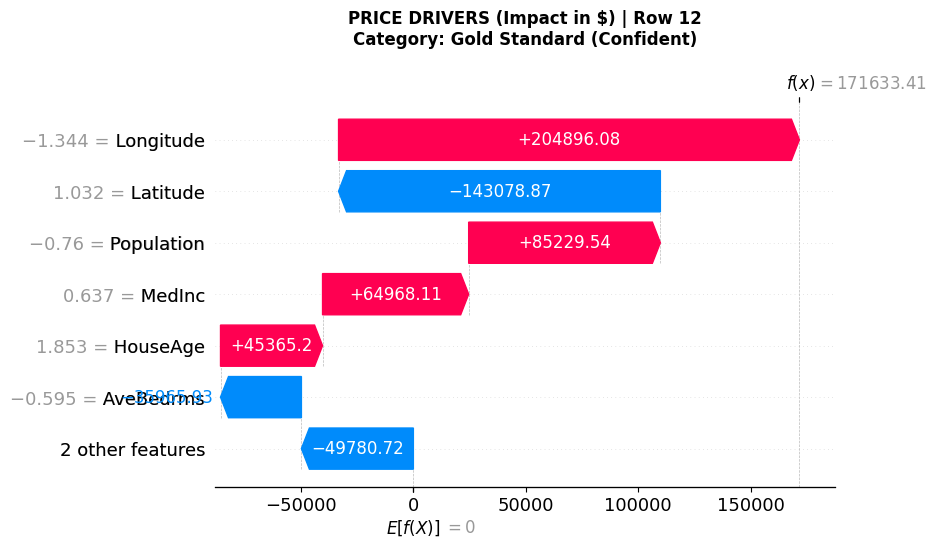

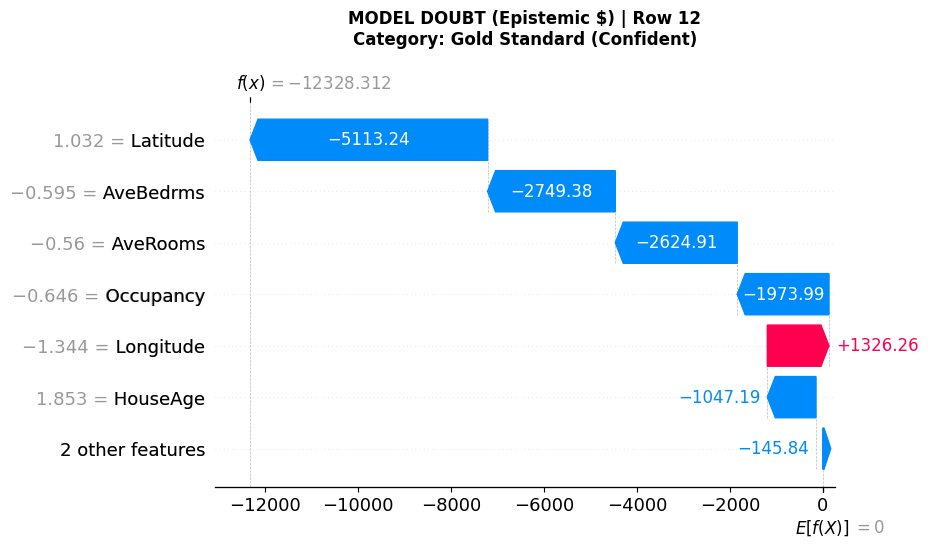

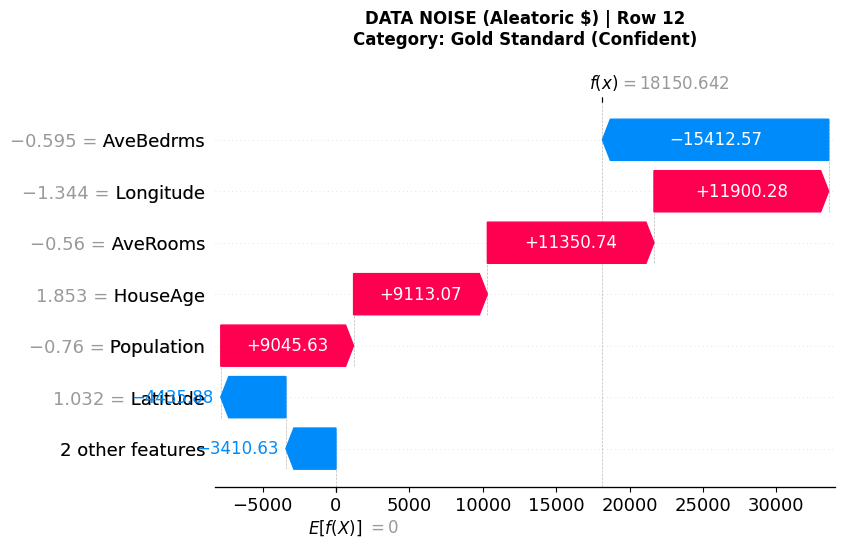

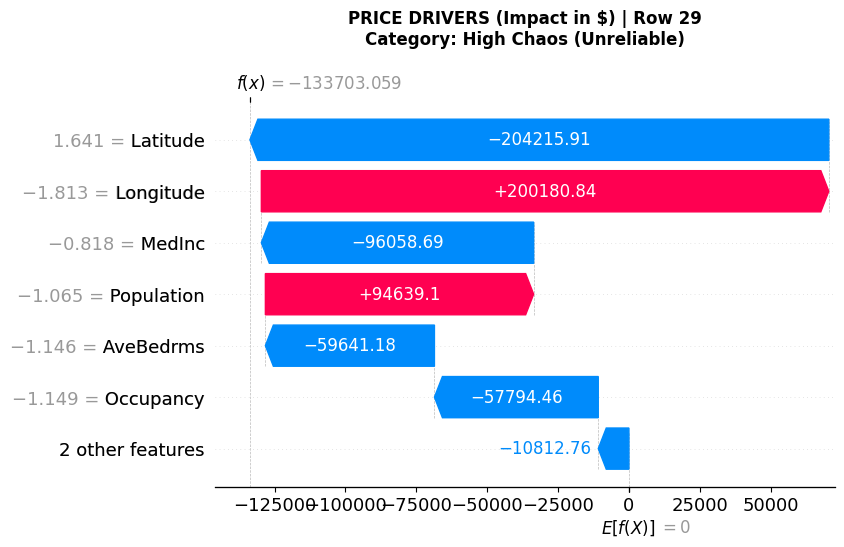

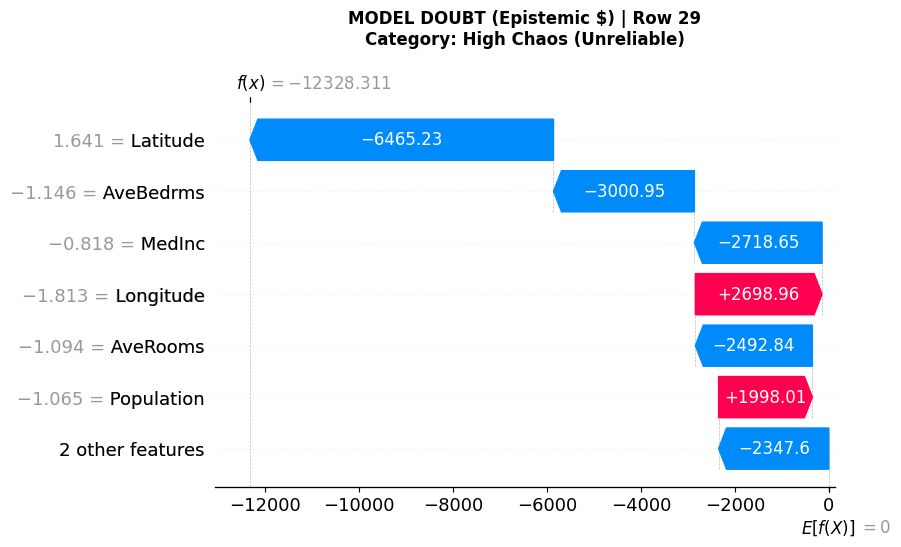

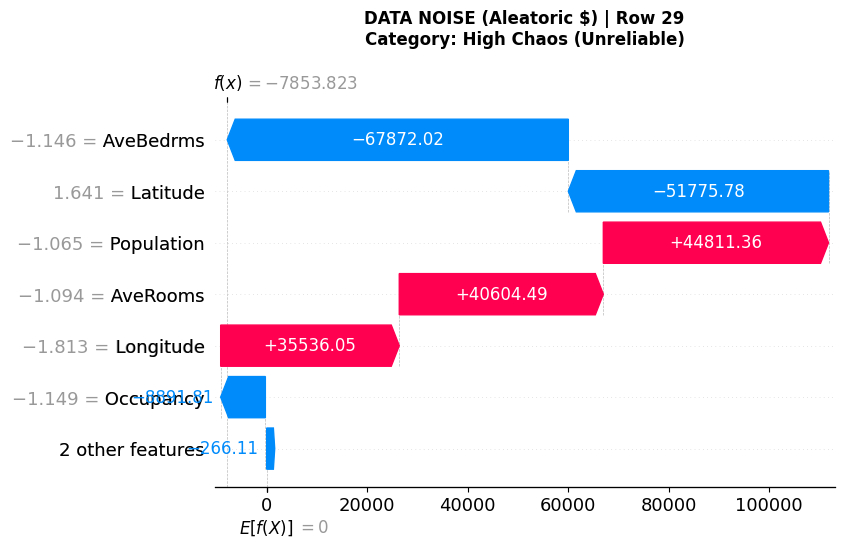

In [ ]:
# --- THE DEEP DIVE: SHAP WATERFALLS FOR PRICE VS. UNCERTAINTY ---

# 1. Selection logic using the quad_df we just built
try:
    # We want the highest signal confident house vs the most chaotic house
    row_HS_LU = quad_df[quad_df['category'] == "High SHAP, Low Unc"]['shap_mag'].idxmax()
    row_chaos = quad_df['unc_mag'].idxmax() # The outlier (Row 20)
    cat_LU, cat_chaos = "Gold Standard (Confident)", "High Chaos (Unreliable)"
    print(f"✅ Selection successful: Row {row_HS_LU} (Confident) and {row_chaos} (Chaos)")
except:
    print("⚠️ Selection Error: Using manual fallback indices.")

# 2. The Updated Plotting Function
def plot_surgical_comparison(idx, category_name):
    # Retrieve the explanation objects we created in the Quadrant cell
    # exp_mean, exp_epistemic, exp_aleatoric
    exps = {
        "PRICE DRIVERS (Impact in $)": sv_results.get('mean'),
        "MODEL DOUBT (Epistemic $)": sv_results.get('epistemic'),
        "DATA NOISE (Aleatoric $)": sv_results.get('aleatoric')
    }

    for title, values in exps.items():
        if values is None: continue

        # Build the specific explanation object for this row
        # We use the index relative to the X_subset used in the quadrant analysis
        exp_obj = shap.Explanation(
            values=values[idx],
            base_values=explainer.expected_value if 'mean' in title.lower() else 0, # Uncertainty usually starts at 0
            data=X_subset[idx],
            feature_names=feature_cols
        )

        plt.figure(figsize=(10, 4))
        shap.plots.waterfall(exp_obj, max_display=7, show=False)

        # Dynamic Title with LaTeX support
        clean_title = title.replace("$", r"\$")
        plt.title(f"{clean_title} | Row {idx}\nCategory: {category_name}",
                  fontsize=12, fontweight='bold', pad=20)
        plt.show()

# 3. Execution
print("\n--- STARTING SURGICAL AUTOPSY ---")
# First, look at the house we trust
plot_surgical_comparison(row_HS_LU, cat_LU)

print("\n" + "="*50 + "\n")

# Then, look at the house that broke the scale
plot_surgical_comparison(row_chaos, cat_chaos)

## 🔴 Distributions

On your own, show me the distribution of these two cool points!

# 🔵 Save the model
Look left! Save to your Google Drive and try to reload, run SHAP and make scatterplots etc... does it work?! To be updated with all losses and variables etc.

In [ ]:
# # Save the model
# model.save('california_housing_model_epistemic.keras')

# # Load it back later
# from tensorflow.keras.models import load_model
# reloaded_model = load_model('california_housing_model_epistemic.keras')

In [ ]:
# import joblib

# # Bundle everything needed to recreate the environment
# artifacts = {
#     'scaler': scaler,
#     'y_mean': y_mean,
#     'y_std': y_std,
#     'feature_cols': feature_cols,
#     'random_seed': 42,           # The master seed
#     'test_size': 0.2,            # Documentation of the split
#     'model_arch': '128-64-Dense' # Metadata for your notes
# }

# joblib.dump(artifacts, 'model_artifacts_epistemic.joblib')

## Read it all back

In [ ]:
import joblib
from tensorflow.keras.models import load_model

# Load the brain
model = load_model('california_housing_model_epistemic.keras')

# Load the translator/metadata
artifacts = joblib.load('model_artifacts_epistemic.joblib')

# Extract what you need from the dictionary
scaler = artifacts['scaler']
y_mean = artifacts['y_mean']
y_std  = artifacts['y_std']

ValueError: File not found: filepath=california_housing_model_epistemic.keras. Please ensure the file is an accessible `.keras` zip file.

If you did it right, you can test all of this on the test partition!